In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36255")
client

Client Scheduler: tcp://127.0.0.1:36255 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 28 Memory: 60.13 GB


In [3]:
from jetstream.post_proc import SingleModelPostProcessor

In [22]:
var_of_interest = 't_prime'
model = 'era5_processed_data'
path_data = '/project2/moyer/jetsream/'
path_postproc = '/home/afarah/public_html/jetstream/' 
path_processed = f'{path_data}{model}/df_lat_20_1D/df_lat_20_1D_{var_of_interest}*'

single = SingleModelPostProcessor(path_to_files=path_processed,
         path_to_save_files=path_postproc+var_of_interest,
         diagnostic_var=var_of_interest,
         season='DJF')

In [23]:
single.dataset

,Array,Chunk
Bytes,11.03 GB,3.23 MB
Shape,"(3420, 280, 1440)","(1, 280, 1440)"
Count,10286 Tasks,3420 Chunks
Type,float64,numpy.ndarray


In [24]:
single.demean(single.dataset.t_prime)

,Array,Chunk
Bytes,11.03 GB,3.23 MB
Shape,"(3420, 280, 1440)","(1, 280, 1440)"
Count,28919 Tasks,3420 Chunks
Type,float64,numpy.ndarray


In [25]:
single.demean(single.dataset.t_prime).to_netcdf('/home/ivanhigueram/scratch-midway2/test_demean.nc4')

In [26]:
single.demeaned_shift(single.dataset)

,Array,Chunk
Bytes,11.03 GB,3.23 MB
Shape,"(3420, 280, 1440)","(1, 280, 1440)"
Count,32431 Tasks,3420 Chunks
Type,float64,numpy.ndarray


In [16]:
single.demeaned_shift(single.dataset).rename({'eff_lat': 'demeaned_shift'}).\
to_netcdf('/scratch/midway2/ivanhigueram/test_demean_shift.nc4')

In [17]:
import xarray as xr


test_shift = xr.open_dataset('/scratch/midway2/ivanhigueram/test_demean_shift.nc4',
                            chunks={'time': 1})

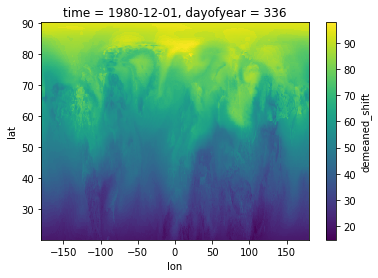

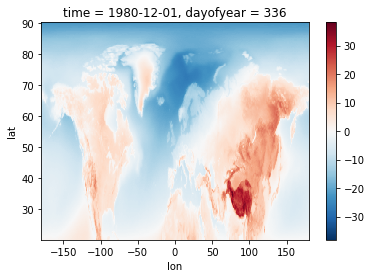

In [21]:
(single.dataset.isel(time=0).eff_lat - test_shift.isel(time=0).demeaned_shift).plot()